In [1]:
import sys
sys.path.insert(0,'/Users/marcosaponara/Documents/GitHub/centipede-bias/mysrc/')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from itertools import product

from egttools.analytical import PairwiseComparison, replicator_equation
from egttools.games import Matrix2PlayerGameHolder
from egttools.utils import calculate_stationary_distribution
from egttools.plotting import draw_invasion_diagram

from egttools.plotting.helpers import (xy_to_barycentric_coordinates,
                                       barycentric_to_xy_coordinates,
                                       find_roots_in_discrete_barycentric_coordinates,
                                       calculate_stability,
                                    )
from egttools.analytical.utils import (find_roots, check_replicator_stability_pairwise_games, )
from egttools.helpers.vectorized import vectorized_replicator_equation, vectorized_barycentric_to_xy_coordinates


from egttools.plotting import Simplex2D, plot_gradients

from utils.centipedeGame import CentipedeGame
from utils.kStrategy import KStrategy
from utils.kernel import brain_unbiased, brain_prosocial, brain_proself

In [3]:
def get_payoffs(nb_steps : int,
                payoff_step0_pl1 : float = 0.4, 
                payoff_step0_pl2 : float = 0.1,
                multiplicative_factor : float = 2.,
               ):
    payoffs_pl1 = np.tile([payoff_step0_pl1, payoff_step0_pl2], nb_steps//2) * multiplicative_factor**np.arange(nb_steps, dtype=float)
    payoffs_pl2 = np.tile([payoff_step0_pl2, payoff_step0_pl1], nb_steps//2) * multiplicative_factor**np.arange(nb_steps, dtype=float)

    # add payoffs in final node
    payoffs_pl1 = np.append(payoffs_pl1, payoff_step0_pl1 * multiplicative_factor ** nb_steps)
    payoffs_pl2 = np.append(payoffs_pl2, payoff_step0_pl2 * multiplicative_factor ** nb_steps)

    return payoffs_pl1, payoffs_pl2

In [4]:
def my_invasion_diagram(Z, nb_steps, beta, eps, ax):
    payoffs_pl1, payoffs_pl2 = get_payoffs(nb_steps)
    nb_k_levels = 3
    k_levels = np.arange(1, nb_k_levels)
    
    start = np.zeros(nb_steps+2, dtype = float)
    start[-2] = 1.
    start[nb_steps//2] = 1.

    start_arrays = np.array([
                            start,
                            ], dtype = float)

    start_k_pairs = list(product(start_arrays, k_levels))

    gamma = 0.
    
    strategy_labels = ["NR"]
    for brain in ["U", "P", "W"]:
        for i in range(1, nb_k_levels):
            strategy_labels.append(brain+fr'({i})')       

    nb_strategies = len(strategy_labels)
    
    strategies = [start]
    for brain in [brain_unbiased, brain_proself, brain_prosocial]:
        matrix = brain(nb_steps, gamma, eps)
        #print(np.round(matrix,2))
        strategy = KStrategy(matrix)

        for pair in start_k_pairs:
            start, k = pair
            strategies.append(strategy.calculate_mixed_strategy(k = k, start = start))

    strategies = np.array(strategies)

    cg = CentipedeGame(payoffs_pl1, payoffs_pl2, strategies)
    game = Matrix2PlayerGameHolder(nb_strategies, cg.payoffs())
    evolver = PairwiseComparison(population_size=Z, game=game)
    transition_matrix, fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(beta)
    stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
    
    plot = draw_invasion_diagram(strategy_labels,
                           1/Z, 
                           fixation_probabilities,
                           stationary_distribution,
                           node_size=2000, 
                           font_size_node_labels=15,
                           #font_size_edge_labels=10,
                           display_edge_labels=False,
                           font_size_sd_labels=15,
                           edge_width=1.5,
                           min_strategy_frequency=0, 
                           ax=ax,
                           max_displayed_label_letters=10,
                         )
    return plot

In [5]:
def my_simplex(Z, nb_steps, eps, ax):
    payoffs_pl1, payoffs_pl2 = get_payoffs(nb_steps)
    
    start = np.zeros(nb_steps+2, dtype = float)
    start[-2] = 1.
    start[nb_steps//2] = 1.

    gamma = 0.
    
    strategy_labels = ["W(1)", "U(1)", "NR",]    
    nb_strategies = len(strategy_labels)
    
    strategies = []
    i=0
    for brain in [brain_prosocial, brain_unbiased,]:
    #for brain in [brain_proself, brain_prosocial]:
        matrix = brain(nb_steps, gamma, eps)
        #print(np.round(matrix,2))
        strategy = KStrategy(matrix)
        strategies.append(strategy.calculate_mixed_strategy(k = 1, start = start))
        
    strategies.append(start)
            
        

    strategies = np.array(strategies)

    cg = CentipedeGame(payoffs_pl1, payoffs_pl2, strategies)
    payoffs = cg.payoffs()
    
    simplex = Simplex2D()

    v = np.asarray(xy_to_barycentric_coordinates(simplex.X, simplex.Y, simplex.corners))

    results = vectorized_replicator_equation(v, payoffs)
    xy_results = vectorized_barycentric_to_xy_coordinates(results, simplex.corners)
    Ux = xy_results[:, :, 0].astype(np.float64)
    Uy = xy_results[:, :, 1].astype(np.float64)
    
    calculate_gradients = lambda u: replicator_equation(u, payoffs)

    roots = find_roots(gradient_function=calculate_gradients,
                       nb_strategies=payoffs.shape[0],
                       nb_initial_random_points=100)
    roots_xy = [barycentric_to_xy_coordinates(root, corners=simplex.corners) for root in roots]

    stability = check_replicator_stability_pairwise_games(roots, payoffs)
    
    plot = (simplex.add_axis(ax=ax)
       .apply_simplex_boundaries_to_gradients(Ux, Uy)
       .draw_triangle()
       .draw_gradients(zorder=0)
       .add_colorbar(shrink=0.4,label_fontsize=17)
       .draw_stationary_points(roots_xy, stability)
       .add_vertex_labels(strategy_labels, epsilon_top = 0.12, epsilon_bottom=0.12, fontsize=20)
       .draw_trajectory_from_roots(lambda u, t: replicator_equation(u, payoffs),
                                   roots,
                                   stability,
                                   trajectory_length=15,
                                   linewidth=1,
                                   step=0.01,
                                   color='k', draw_arrow=True, arrowdirection='right', arrowsize=15, zorder=3, arrowstyle='fancy')
       .draw_scatter_shadow(lambda u, t: replicator_equation(u, payoffs), 25, color='gray', marker='.', s=0.1, zorder=0)
          )
    
    return plot

In [6]:
def my_gradient(Z, nb_steps, beta, eps_values, ax):
    payoffs_pl1, payoffs_pl2 = get_payoffs(nb_steps)
    
    start = np.zeros(nb_steps+2, dtype = float)
    start[-2] = 1.
    start[nb_steps//2] = 1.

    gamma = 0.
    
    strategy_labels = ["W(1)", "NR",]    
    nb_strategies = len(strategy_labels)
    
    xx = np.arange(Z+1)/Z
    
    for eps in eps_values:
    
        strategies = []
        matrix = brain_prosocial(nb_steps, gamma, eps)
        #print(np.round(matrix,2))
        strategy = KStrategy(matrix)
        strategies.append(strategy.calculate_mixed_strategy(k = 1, start = start))
        strategies.append(start)

        strategies = np.array(strategies)

        cg = CentipedeGame(payoffs_pl1, payoffs_pl2, strategies)
        game = Matrix2PlayerGameHolder(nb_strategies, cg.payoffs())
        evolver = PairwiseComparison(population_size=Z, game=game)


        gradients = np.array([evolver.calculate_gradient_of_selection(beta, np.array([x, Z - x])) 
                              for x in range(Z+1)])
        #print(np.isclose(gradients[:,0],0.).any())
        #print(gradients[:,0])

        ax.plot(xx, gradients[:,0], marker="o",markersize=2, label=fr'$\epsilon=${eps}')
        
    ax.set_xlabel("frequency of W(1)", fontsize=17)
    ax.set_ylabel("gradient of selection", fontsize=17)
    ax.axhline(color='black')
    ax.legend(fontsize=12)

In [7]:
def my_sd(Z, nb_steps, beta, eps_values, ax):
    payoffs_pl1, payoffs_pl2 = get_payoffs(nb_steps)
    
    start = np.zeros(nb_steps+2, dtype = float)
    start[-2] = 1.
    start[nb_steps//2] = 1.

    gamma = 0.
    
    strategy_labels = ["W(1)", "NR",]    
    nb_strategies = len(strategy_labels)
    
    xx = np.arange(Z+1)/Z
    
    for eps in eps_values:
    
        strategies = []
        matrix = brain_prosocial(nb_steps, gamma, eps)
        #print(np.round(matrix,2))
        strategy = KStrategy(matrix)
        strategies.append(strategy.calculate_mixed_strategy(k = 1, start = start))
        strategies.append(start)

        strategies = np.array(strategies)

        cg = CentipedeGame(payoffs_pl1, payoffs_pl2, strategies)
        #print(cg.payoffs())
        game = Matrix2PlayerGameHolder(nb_strategies, cg.payoffs())
        evolver = PairwiseComparison(population_size=Z, game=game)


        transition_matrix = evolver.calculate_transition_matrix(beta=1, mu=0.01)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        #print(stationary_distribution)

        ax.plot(xx, stationary_distribution[::-1], marker="o", markersize=2,label=fr'$\epsilon=${eps}') 
    ax.set_xlabel("frequency of W(1)", fontsize=17)
    ax.set_ylabel('stationary distribution', fontsize=17)
    #ax.legend(fontsize=12)
    


In [8]:
Z = 100

nb_steps, beta, eps = 6, 0.063, 0.186 # Jap

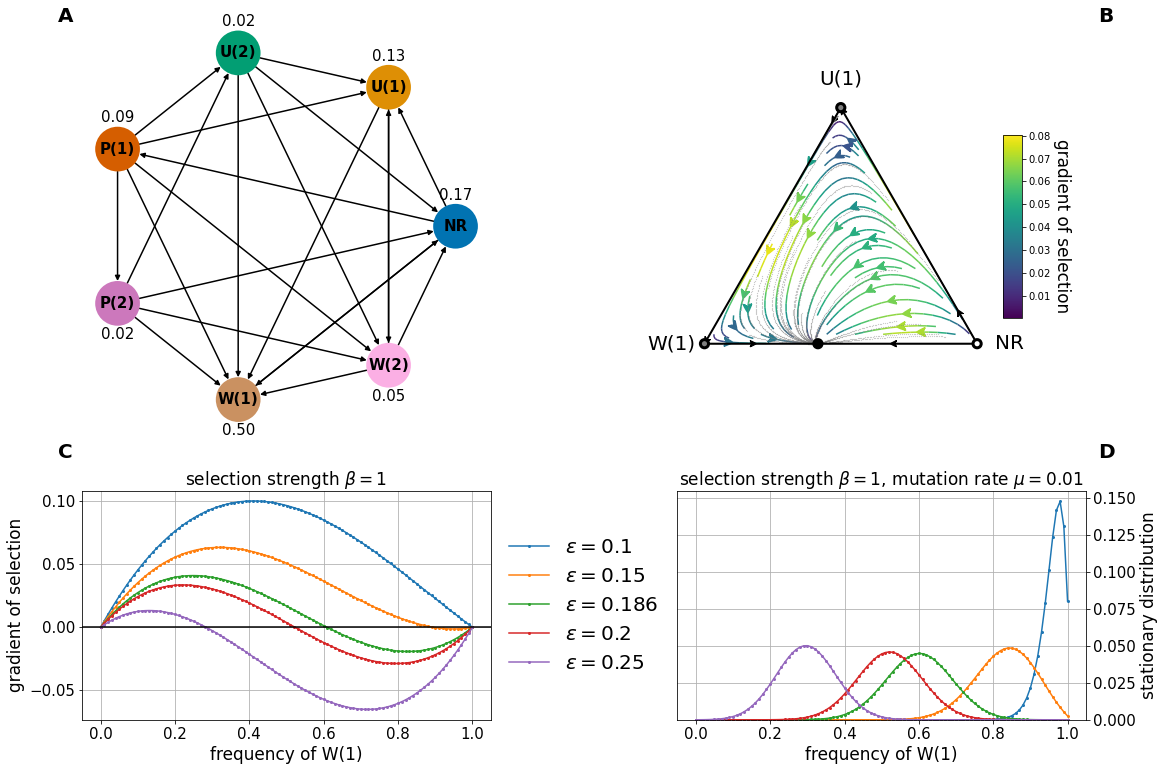

In [9]:
eps_values = [0.1, 0.15, eps, 0.2, 0.25,]


fig, ax = plt.subplots(2, 2, figsize=(17,11), gridspec_kw={'height_ratios': [2,1]})
#fig.suptitle(fr'$Z=${Z}, $\beta=${beta}, $\epsilon=${eps}', fontsize=20)


my_invasion_diagram(Z, nb_steps, beta, eps, ax[0,0])


my_simplex(Z, nb_steps, eps, ax[0,1])


my_gradient(Z, nb_steps, 1, eps_values, ax[1,0])

my_sd(Z, nb_steps, 1, eps_values, ax[1,1])

ax[0,0].axis('off')

ax[0,0].set_aspect(aspect='equal', anchor='C')

ax[0,1].set_aspect(aspect='equal', anchor='C')
ax[0,1].set_xlim((-.1, 1.1))
#ax[0,1].set_ylim((-.02, simplex.top_corner + 0.1))
ax[0,1].axis('off')

ax[1,0].grid()
ax[1,1].grid()

ax[1,1].set_ylim(0.,)

ax[1, 0].set_title(r'selection strength $\beta=1$', fontsize=17)
ax[1, 1].set_title(r'selection strength $\beta=1$, mutation rate $\mu=0.01$', fontsize=17)

fig.text(0.05, .95, 'A', fontsize=20, fontweight='heavy')
fig.text(.9, .95, 'B', fontsize=20, fontweight='heavy')
fig.text(0.05, .4, 'C', fontsize=20, fontweight='heavy')
fig.text(.9, .4, 'D', fontsize=20, fontweight='heavy') 

ax[1,0].xaxis.set_tick_params(labelsize=15)
ax[1,1].xaxis.set_tick_params(labelsize=15)

ax[1,0].yaxis.set_tick_params(labelsize=15)
ax[1,1].yaxis.set_tick_params(labelsize=15)

ax[1,0].legend([fr'$\epsilon=${e}' for e in eps_values], 
              loc='center left', bbox_to_anchor=(1., 0.5), fontsize = 20, frameon=False,)
ax[1,1].yaxis.set_label_position("right")
ax[1,1].yaxis.tick_right()

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave some space on the right for the legend

plt.savefig(f'./figures/diagram-Z{Z}.png', format='png')
plt.savefig(f'./figures/diagram-Z{Z}.eps', format='eps')
plt.show() # display

In [10]:
# source code:
# https://github.com/Socrats/EGTTools/blob/docs/src/egttools/plotting/simplex2d.py